#### **Regression-Analysis-Team-Project** by Team 1

##### Importing necessary libraries

In [57]:
####### what's in startup file #######
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import sklearn as sk

import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
# import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()

In [58]:
####### what's not in startup file #######
from scipy import stats

# visualization in jupyter
%matplotlib inline   

# ignore warning messeges
import warnings
warnings.filterwarnings('ignore')

import time

##### Importing data
- Properties Data

In [59]:
prop16 = pd.read_csv('data/properties_2016.csv')
prop17 = pd.read_csv('data/properties_2017.csv')

- Train Data

In [60]:
train16 = pd.read_csv('data/train_2016_v2.csv', parse_dates=["transactiondate"])
train17 = pd.read_csv('data/train_2017.csv', parse_dates=["transactiondate"])

- Submission Sample

In [61]:
submission_form = pd.read_csv('data/sample_submission.csv')

In [62]:
# traing16을 기준으로 prop16을 merge
merged16 = pd.merge(train16, prop16, on="parcelid", how="left")

In [63]:
# traing17을 기준으로 prop17을 merge
merged17 = pd.merge(train17, prop17, on="parcelid", how="left")

In [64]:
merged = pd.concat([merged16, merged17]).reset_index(drop=True)
merged.tail()

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
167883,10833991,-0.002245,2017-09-20,1.0,NaN,NaN,3.0,3.0,NaN,8.0,...,NaN,NaN,265000.0,379000.0,2016.0,114000.0,4685.34,NaN,NaN,6.037132e+13
167884,11000655,0.020615,2017-09-20,NaN,NaN,NaN,2.0,2.0,NaN,6.0,...,NaN,NaN,70917.0,354621.0,2016.0,283704.0,4478.43,NaN,NaN,6.037101e+13
167885,17239384,0.013209,2017-09-21,NaN,NaN,NaN,2.0,4.0,NaN,NaN,...,1.0,NaN,50683.0,67205.0,2016.0,16522.0,1107.48,NaN,NaN,6.111008e+13
167886,12773139,0.037129,2017-09-21,1.0,NaN,NaN,1.0,3.0,NaN,4.0,...,NaN,NaN,32797.0,49546.0,2016.0,16749.0,876.43,NaN,NaN,6.037434e+13
167887,12826780,0.007204,2017-09-25,NaN,NaN,NaN,2.0,3.0,NaN,6.0,...,NaN,NaN,140000.0,522000.0,2016.0,382000.0,6317.15,NaN,NaN,6.037503e+13


In [65]:
merged_des = merged.describe(include='all').transpose()
merged_des["missing_ratio"] = 1-(merged_des["count"]/merged.shape[0])
merged_des["dtype"] = merged.dtypes
merged_des.reset_index().tail()

,index,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max,missing_ratio,dtype
55,landtaxvaluedollarcnt,167851,NaN,NaN,NaN,NaN,NaN,288880,445645,22,83730,197776,355334,4.89522e+07,0.000220385,float64
56,taxamount,167843,NaN,NaN,NaN,NaN,NaN,5989.52,7214.73,19.92,2798.07,4501.04,6914.16,586639,0.000268036,float64
57,taxdelinquencyflag,4683,1,Y,4683,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.972106,object
58,taxdelinquencyyear,4683,NaN,NaN,NaN,NaN,NaN,13.8272,2.42166,3,13,14,15,99,0.972106,float64
59,censustractandblock,167002,NaN,NaN,NaN,NaN,NaN,6.04939e+13,1.05414e+12,6.0371e+13,6.03731e+13,6.0376e+13,6.05904e+13,4.8303e+14,0.00527733,float64


##### Data의 format 등에 먼저 전처리를 해줄 수 있는 부분

In [66]:
# transaction date을 year와 month로 분리해 줌
merged['transaction_year'] = merged['transactiondate'].dt.year
merged['transaction_month'] = merged['transactiondate'].dt.month

# taxdelinquency는 "Y"를 True로 바꾸어 줌 (다른 dummy 변수들은 1이나 True로 되어 있음)
merged['taxdelinquencyflag'] = merged['taxdelinquencyflag'].replace('Y',True)
merged['taxdelinquencyflag'] = merged['taxdelinquencyflag'].fillna(False)

# taxdelinquencyyear는 4자리의 년도로 format을 맞춰줌
merged["taxdelinquencyyear"] = merged["taxdelinquencyyear"].apply(lambda x: x + 2000 if x <= 17 else x + 1900)

# 위도 경도를 원래 단위로 맞춰줌
merged["latitude"] = merged["latitude"]/1000000
merged["longitude"] = merged["longitude"]/1000000

##### categorical / numerical variable 구분하기

In [67]:
vars = merged_des.reset_index()["index"].tolist()

cat_vars = ['transactiondate', 'transaction_year', 'transaction_month',
            'rawcensustractandblock', 'censustractandblock', 'fips',
            'regionidcity', 'regionidcounty', 'regionidneighborhood', 'regionidzip', 
            'architecturalstyletypeid', 'decktypeid', 'buildingclasstypeid', 'storytypeid',
            'typeconstructiontypeid', 'propertycountylandusecode', 'propertylandusetypeid',
            'propertyzoningdesc', 'taxdelinquencyflag', 'taxdelinquencyyear', 'assessmentyear',
            'heatingorsystemtypeid', 'airconditioningtypeid', 'hashottuborspa', 'fireplaceflag',
            'pooltypeid10', 'pooltypeid2', 'pooltypeid7']

num_vars = [i for i in vars if i not in cat_vars]

num_vars.remove('parcelid')
num_vars.remove('logerror')

print("number of categorical variables:", len(cat_vars))
print("number of numerical variables:", len(num_vars))

number of categorical variables: 28
number of numerical variables: 32


##### 카테고리 변수 중 float type이 많음 → 필요할 경우 str으로 바꿔주기
- str: 'architecturalstyletypeid', 'rawcensustractandblock', 'censustractandblock', 'regionidcounty', 'fips', 'regionidcity', 'regionidcounty', 'regionidneighborhood', 'decktypeid', 'buildingclasstypeid', 'storytypeid', 'typeconstructiontypeid', 'propertylandusetypeid', 'heatingorsystemtypeid', 'airconditioningtypeid'
    - 일단 년도 변수는 계산 등의 조작 가능성을 고려해 바꿔주지 않음: 'assessmentyear', 'taxdelinquencyyear'
- boolean: 'fireplaceflag', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'hashottuborspa'

In [68]:
def cat_to_str(column_name):
    merged[column_name] = merged[column_name].astype("str")
    merged[column_name][merged[column_name] == 'nan'] = np.nan

In [69]:
ls_c_to_s = ['architecturalstyletypeid', 'rawcensustractandblock', 'censustractandblock',
             'regionidcounty', 'fips', 'regionidcity', 'regionidcounty', 'regionidneighborhood',
             'decktypeid', 'buildingclasstypeid', 'storytypeid', 'typeconstructiontypeid',
             'propertylandusetypeid', 'heatingorsystemtypeid', 'airconditioningtypeid']

for var in ls_c_to_s:
    cat_to_str(var)

In [70]:
# dummy 변수를 True/False로 인코딩
def cat_to_bln(column_name):
    merged[column_name] = merged[column_name].replace(1,True)
    merged[column_name] = merged[column_name].fillna(False)

In [71]:
c_to_b = ['fireplaceflag', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'hashottuborspa']

for var in c_to_b:
    cat_to_bln(var)

In [72]:
merged_des = merged.describe(include='all').transpose()
merged_des["missing_ratio"] = 1-(merged_des["count"]/merged.shape[0])
merged_des["dtype"] = merged.dtypes
merged_des

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max,missing_ratio,dtype
parcelid,167888,NaN,NaN,NaN,NaN,NaN,1.29954e+07,3.01607e+06,1.07117e+07,1.1549e+07,1.25406e+07,1.42193e+07,1.67689e+08,0,int64
logerror,167888,NaN,NaN,NaN,NaN,NaN,0.0139063,0.165706,-4.65542,-0.0253,0.006,0.0392,5.263,0,float64
transactiondate,167888,616,2017-06-30 00:00:00,1195,2016-01-01 00:00:00,2017-09-25 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,datetime64[ns]
airconditioningtypeid,53788,6,1.0,49854,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.67962,object
architecturalstyletypeid,468,6,7.0,394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.997212,object
basementsqft,93,NaN,NaN,NaN,NaN,NaN,695.376,583.952,38,280,588,819,3560,0.999446,float64
bathroomcnt,167854,NaN,NaN,NaN,NaN,NaN,2.28827,1.00084,0,2,2,3,20,0.000202516,float64
bedroomcnt,167854,NaN,NaN,NaN,NaN,NaN,3.04174,1.14913,0,2,3,4,16,0.000202516,float64
buildingclasstypeid,31,2,4.0,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999815,object
buildingqualitytypeid,107173,NaN,NaN,NaN,NaN,NaN,6.01546,1.8828,1,4,7,7,12,0.36164,float64


## 2.2 Exploring Target Variable: logerror

In [73]:
# cencus와 rawcensus의 앞 네자리로 변수를 만들고 다른 변수들과 묶기
merged["census_1"] = merged["censustractandblock"].astype("str").apply(lambda x: x[:4])
merged["census_1"][merged["census_1"] == 'nan'] = np.nan
merged["raw_census_1"] = merged["rawcensustractandblock"].astype("str").apply(lambda x: x[:4])
merged["raw_census_1"][merged["raw_census_1"] == 'nan'] = np.nan
county_df = merged[["fips", "regionidcounty", "census_1", "raw_census_1","logerror"]].tail()
county_df.tail()

,fips,regionidcounty,census_1,raw_census_1,logerror
167883,6037.0,3101.0,6037,6037,-0.002245
167884,6037.0,3101.0,6037,6037,0.020615
167885,6111.0,2061.0,6111,6111,0.013209
167886,6037.0,3101.0,6037,6037,0.037129
167887,6037.0,3101.0,6037,6037,0.007204


In [74]:
# censustractandblock & rawcensustractandblock의 5-10자리 부분: census tract → class가 3000개 이상이라 너무 많은 것으로 생각됨
merged["census_2"] = merged["censustractandblock"].astype("str").apply(lambda x: x[4:10])
merged["census_2"][merged["census_2"] == ""] = np.nan
census_2 = pd.DataFrame(merged["census_2"])
census_2 = census_2.groupby("census_2").size().reset_index(name='counts')

merged["raw_census_2"] = merged["rawcensustractandblock"].astype("str").apply(lambda x: x[4:11])
merged["raw_census_2"][merged["raw_census_2"] == ""] = np.nan
raw_census_2 = pd.DataFrame(merged["raw_census_2"])
raw_census_2 = raw_census_2.groupby("raw_census_2").size().reset_index(name='counts')

In [75]:
# censustractandblock & rawcensustractandblock의 5-10자리 부분 중 첫째 자리로 카테고리화 (카테고리 수를 줄임)
merged["census_3"] = merged["censustractandblock"].astype("str").apply(lambda x: x[4:5])
merged["census_3"][merged["census_3"] == ''] = np.nan
census_3 = pd.DataFrame(merged["census_3"])
census_3 = census_3.groupby("census_3").size().reset_index(name='counts')

merged["raw_census_3"] = merged["rawcensustractandblock"].astype("str").apply(lambda x: x[4:5])
merged["raw_census_3"][merged["raw_census_3"] == ''] = np.nan
raw_census_3 = pd.DataFrame(merged["raw_census_3"])
raw_census_3 = raw_census_3.groupby("raw_census_3").size().reset_index(name='counts')

In [76]:
# censustractandblock & rawcensustractandblock의 1-5자리로 카테고리화
merged["census_4"] = merged["censustractandblock"].astype("str").apply(lambda x: x[:5])
merged["census_4"][merged["census_4"] == 'nan'] = np.nan
census_4 = pd.DataFrame(merged["census_4"])
census_4 = census_4.groupby("census_4").size().reset_index(name='counts')

merged["raw_census_4"] = merged["rawcensustractandblock"].astype("str").apply(lambda x: x[:5])
merged["raw_census_4"][merged["raw_census_4"] == 'nan'] = np.nan
raw_census_4 = pd.DataFrame(merged["raw_census_4"])
raw_census_4 = raw_census_4.groupby("raw_census_4").size().reset_index(name='counts')

In [77]:
### 입력오류라고 보고 NaN값 처리
merged["regionidzip"][merged["regionidzip"]>=100000] = np.nan

In [78]:
# 첫글자로 새로운 변수 만들기 (첫 글자로 카테고리화)
merged["propertyzoningdesc_1"] = merged["propertyzoningdesc"].astype("str").apply(lambda x: x[:1])
merged["propertyzoningdesc_1"][merged["propertyzoningdesc_1"] == "n"] = np.nan

In [79]:
# 세번째 글자로 새로운 변수 만들기
merged["propertyzoningdesc_3"] = merged["propertyzoningdesc"].astype("str").apply(
    lambda x: x.replace("&", "").replace("-", "").replace(" ", ""))
merged["propertyzoningdesc_3"] = merged["propertyzoningdesc_3"].apply(lambda x: x[2:3])
merged["propertyzoningdesc_3"][merged["propertyzoningdesc_3"] == "n"] = np.nan
merged["propertyzoningdesc_3"][merged["propertyzoningdesc_3"] == ""] = np.nan

In [80]:
merged["taxdelinquencyyear_past"] = merged["transaction_year"] - merged["taxdelinquencyyear"]

## **3. Feature Engineering**

### 3.1 Missing Values

#### 3.1.1 Status of missing values
- 데이터에 missing value가 상당히 많음, missing value의 비중을 높은 순으로 살펴보자

In [81]:
merged_missing = pd.DataFrame(merged_des["missing_ratio"].sort_values(ascending=False))
merged_missing.reset_index()

,index,missing_ratio
0,buildingclasstypeid,0.999815
1,finishedsquarefeet13,0.999553
2,storytypeid,0.999446
3,basementsqft,0.999446
4,yardbuildingsqft26,0.999017
5,architecturalstyletypeid,0.997212
6,typeconstructiontypeid,0.996891
7,finishedsquarefeet6,0.995193
8,decktypeid,0.992424
9,poolsizesum,0.989052


#### 3.1.3 Missing Values processing

#### 일부 변수 추가 후 categorical / numerical 새로 분류
- poolcnt는 dummy variable로 재분류함 (True/False)

In [82]:
merged_1 = merged.copy()
merged_1.tail()

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,raw_census_1,census_2,raw_census_2,census_3,raw_census_3,census_4,raw_census_4,propertyzoningdesc_1,propertyzoningdesc_3,taxdelinquencyyear_past
167883,10833991,-0.002245,2017-09-20,1.0,NaN,NaN,3.0,3.0,NaN,8.0,...,6037,131900,1319.00,1,1,60371,60371,L,R,NaN
167884,11000655,0.020615,2017-09-20,NaN,NaN,NaN,2.0,2.0,NaN,6.0,...,6037,101400,1014.00,1,1,60371,60371,L,R,NaN
167885,17239384,0.013209,2017-09-21,NaN,NaN,NaN,2.0,4.0,NaN,NaN,...,6111,008402,0084.02,0,0,61110,61110,NaN,NaN,NaN
167886,12773139,0.037129,2017-09-21,1.0,NaN,NaN,1.0,3.0,NaN,4.0,...,6037,433802,4338.02,4,4,60374,60374,S,R,NaN
167887,12826780,0.007204,2017-09-25,NaN,NaN,NaN,2.0,3.0,NaN,6.0,...,6037,503402,5034.02,5,5,60375,60375,W,R,NaN


In [83]:
vars = merged_des.reset_index()["index"].tolist()
vars.append("taxdelinquencyyear_past")

cat_vars = ['transactiondate',"transaction_year", "transaction_month", 'fips',
            'rawcensustractandblock', 'censustractandblock', "raw_census_1", "census_1",
            "raw_census_2", "census_2", "raw_census_3", "census_3", "raw_census_4", "census_4",
            'regionidcounty', 'regionidcity', 'regionidzip', 'regionidneighborhood', 'architecturalstyletypeid',
            'decktypeid', 'buildingclasstypeid', 'storytypeid', 'typeconstructiontypeid', 
            'propertycountylandusecode', 'propertylandusetypeid', 'propertyzoningdesc', "propertyzoningdesc_1", "propertyzoningdesc_3",            
            'taxdelinquencyflag', 'taxdelinquencyyear', 'assessmentyear',
            'heatingorsystemtypeid', 'airconditioningtypeid', 'hashottuborspa', 'fireplaceflag',
            'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'poolcnt']

num_vars = [i for i in vars if i not in cat_vars]

num_vars.remove('parcelid')
num_vars.remove('logerror')

print("number of categorical variables:", len(cat_vars))
print("number of numerical variables:", len(num_vars))

number of categorical variables: 39
number of numerical variables: 32


#### (1) numerical variables:

##### 집 면적에 관련된 실수 변수
- imputation을 어떻게 할 거라는 설명!

In [84]:
def num_imputation(df):
    for var in num_vars:
        if var in ["garagecarcnt", "numberofstories"]:
            df[var] = df[var].fillna(1)
        elif var in ["buildingqualitytypeid", "roomcnt", "bedroomcnt", "unitcnt", 'bathroomcnt', 
                     'calculatedbathnbr', 'fullbathcnt', 'threequarterbathnbr', 'yearbuilt']:
            a = df[var].mode()
            df[var] = df[var].fillna(int(a[0]))
        elif var in ['finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
                     'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
                     'finishedsquarefeet50', 'finishedsquarefeet6', 'garagetotalsqft', 'lotsizesquarefeet',
                     'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'structuretaxvaluedollarcnt', 'taxamount',
                     'latitude', 'longitude']:
            df[var] = df[var].fillna(df[var].mean())
        else:    # ['poolsizesum', 'fireplacecnt', 'yardbuildingsqft17', 'yardbuildingsqft26', "poolsizesum","taxdelinquencyyear_past"]
            df[var] = df[var].fillna(0) 

In [85]:
num_imputation(merged_1)

#### (2) dummy/categorical variables:

In [86]:
def cat_imputation(df):
    for var in cat_vars:                  
        if var in ['taxdelinquencyyear', 'assessmentyear']:
            df[var] = df[var].fillna(0)
        elif var == "poolcnt":
            df[var] = df[var].replace(1, True)
            df[var] = df[var].fillna(False)            
        elif var == "decktypeid":
            df[var] = df[var].replace('66.0', True)
            df[var] = df[var].fillna(False)         
        else:
            a = df[var].mode()
            df[var] = df[var].fillna(a[0])

In [87]:
cat_imputation(merged_1)

#### (3) imputation 후 missing value ratio 다시 체크

In [88]:
merged_1_des = merged_1.describe(include='all').transpose()
merged_1_des["missing_ratio"] = 1-(merged_1_des["count"]/merged_1.shape[0])
merged_1_des["dtype"] = merged_1.dtypes
merged_1_missing = pd.DataFrame(merged_1_des["missing_ratio"].sort_values(ascending=False))
merged_1_missing.reset_index()

,index,missing_ratio
0,taxdelinquencyyear_past,0
1,propertylandusetypeid,0
2,fips,0
3,fireplacecnt,0
4,fullbathcnt,0
5,garagecarcnt,0
6,garagetotalsqft,0
7,hashottuborspa,0
8,heatingorsystemtypeid,0
9,latitude,0


### 3.2 Feature Correlation

#### 3.2.1 Numerical Features

In [89]:
num_df = merged_1[num_vars]
num_df["logerror"] = merged_1["logerror"]

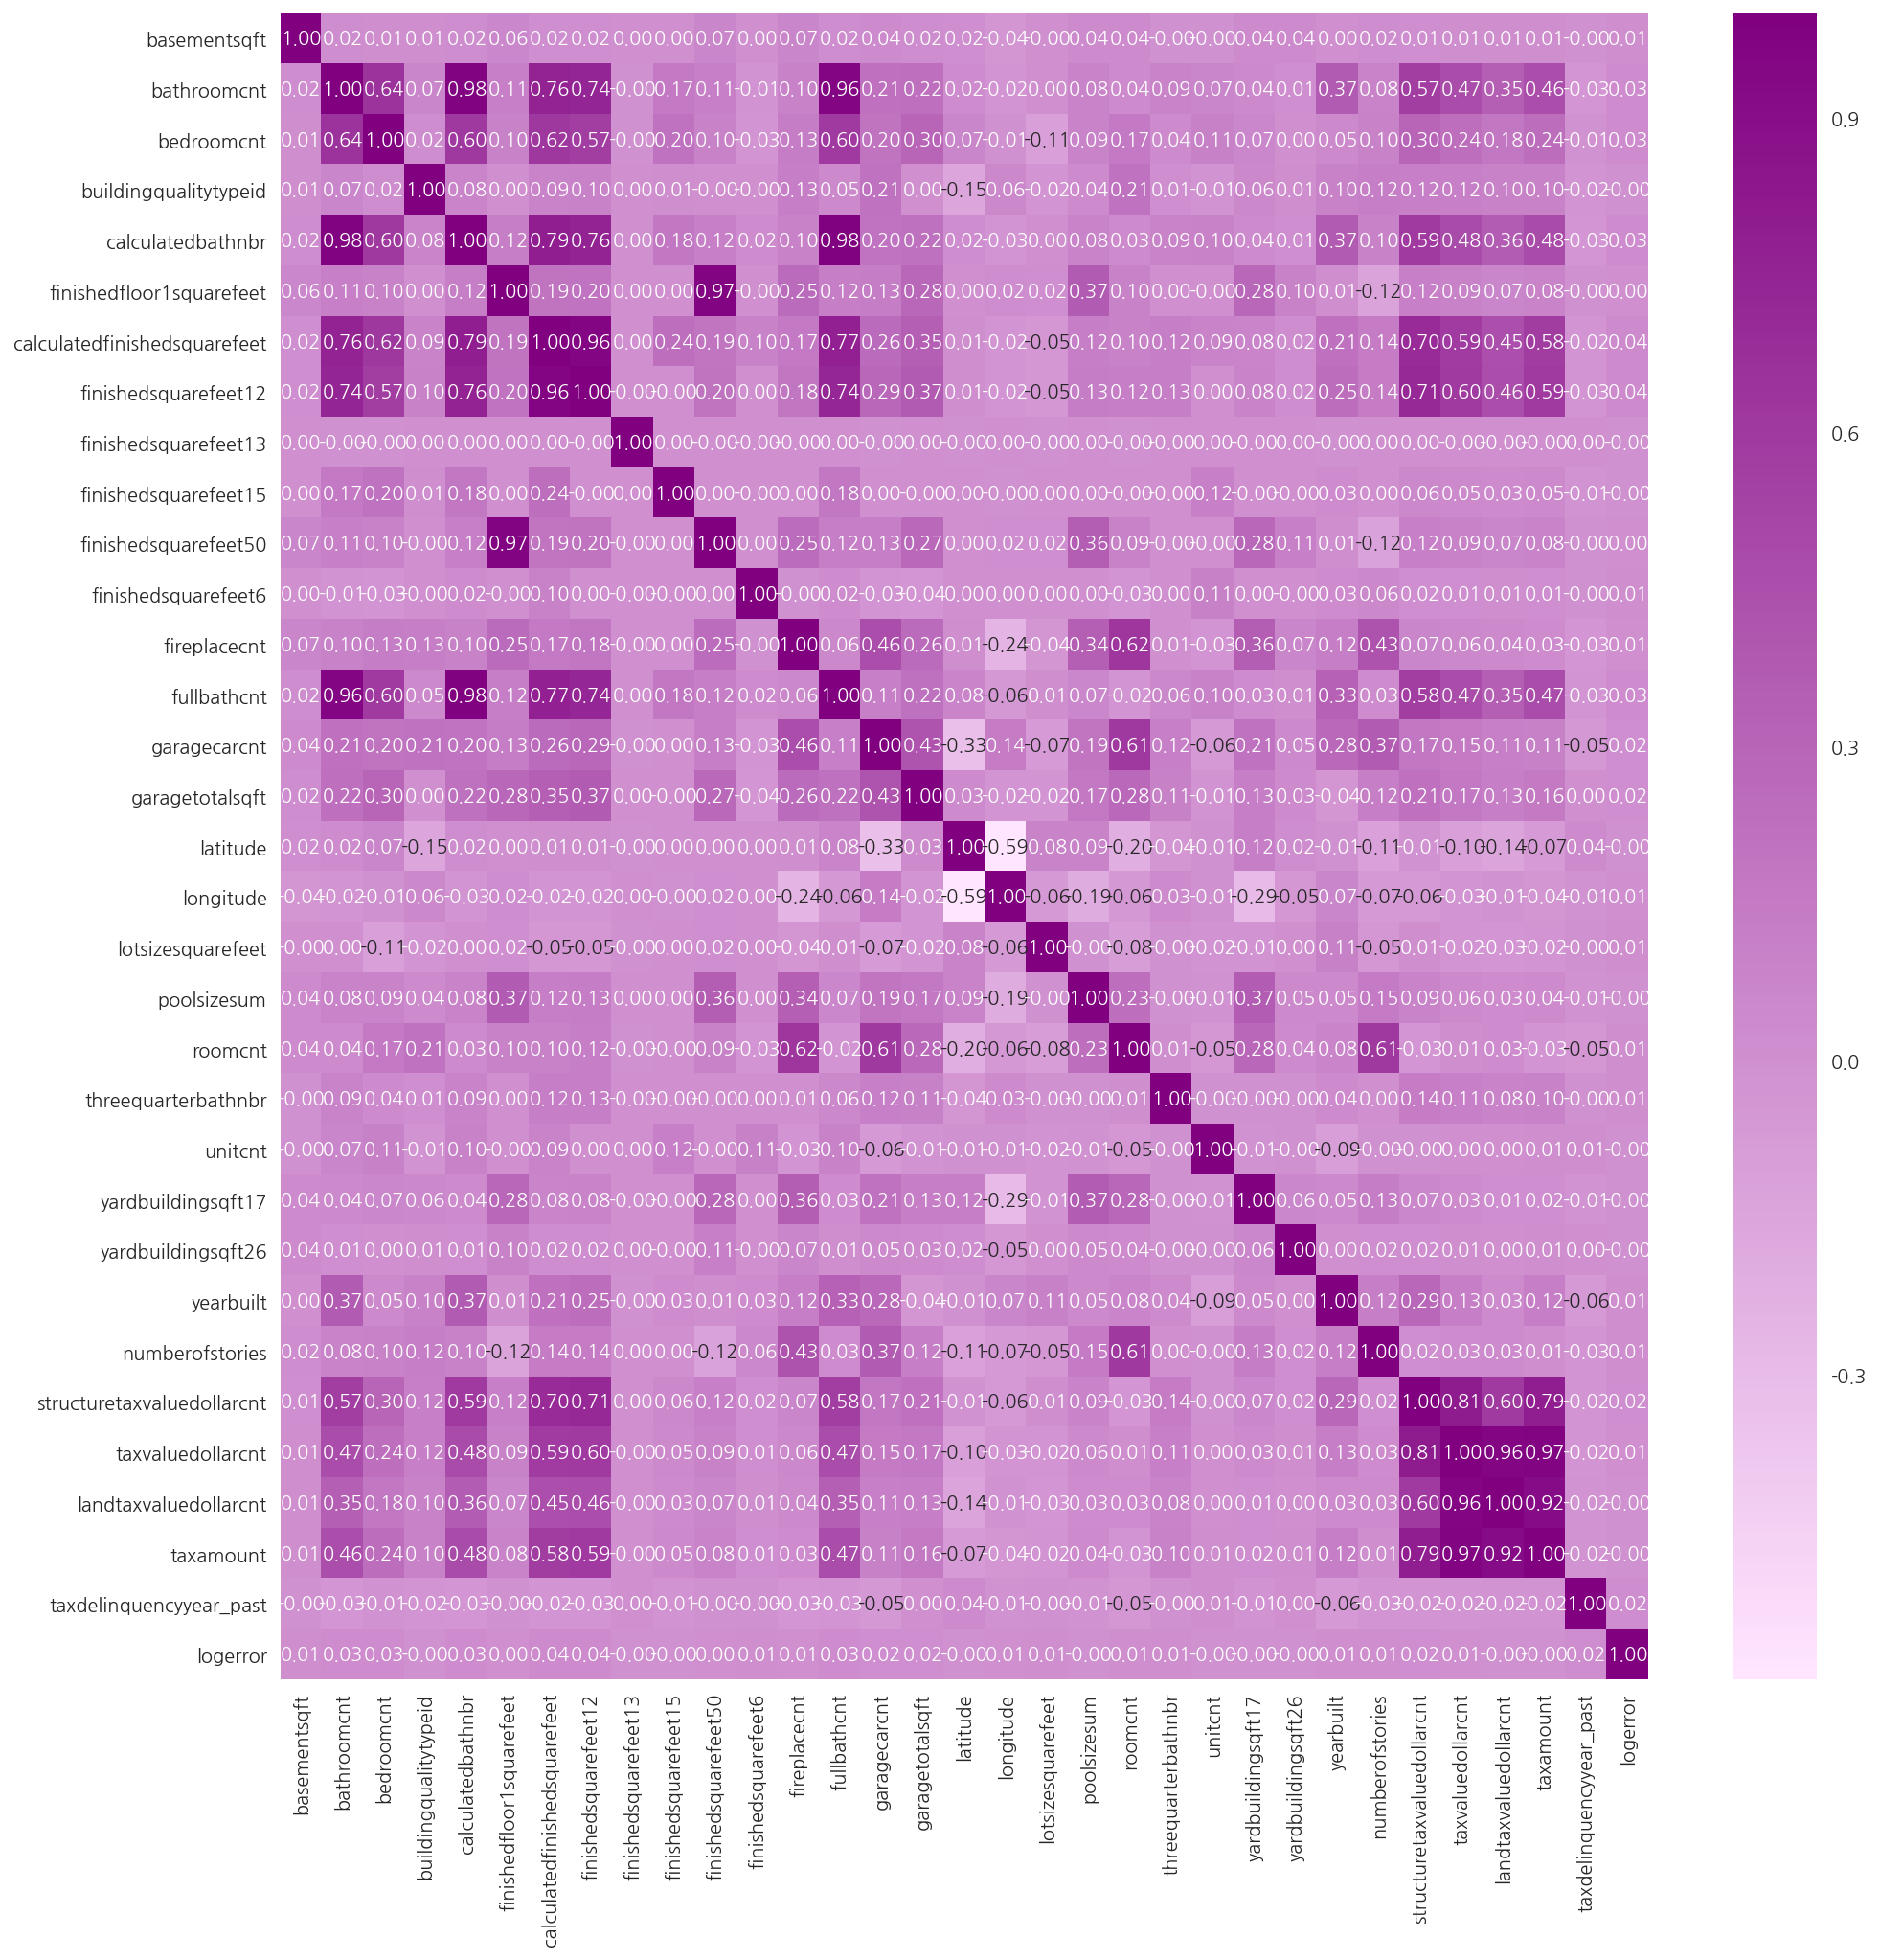

In [33]:
plt.figure(figsize=(16, 16))
cmap = sns.light_palette("purple", as_cmap=True)
sns.heatmap(num_df.corr(), annot=True, fmt='3.2f', cmap=cmap)
plt.show()

#### 3.2.2 Categorical Features

In [34]:
cat_df = merged_1[cat_vars]
cat_df["logerror"] = merged_1["logerror"]

### 3.3 Determination of outliers and variables using OLS model

#### 3.3.1 Numerical Feature만 이용한 모델

In [35]:
# 전체 numerical features
model_n = sm.OLS.from_formula("logerror ~ basementsqft + bathroomcnt + bedroomcnt + calculatedbathnbr +\
finishedfloor1squarefeet + calculatedfinishedsquarefeet + finishedsquarefeet12 + finishedsquarefeet13 +\
finishedsquarefeet15 + finishedsquarefeet50 + finishedsquarefeet6 + fireplacecnt + fullbathcnt + garagecarcnt + garagetotalsqft +\
buildingqualitytypeid + latitude + longitude + lotsizesquarefeet + poolsizesum + roomcnt + threequarterbathnbr +\
unitcnt + yardbuildingsqft17 + yardbuildingsqft26 + yearbuilt + numberofstories + structuretaxvaluedollarcnt + taxvaluedollarcnt +\
landtaxvaluedollarcnt + taxamount + taxdelinquencyyear_past", data=merged_1, missing='drop')
print(model_n.fit().summary())

                            OLS Regression Results                            
Dep. Variable:               logerror   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     26.43
Date:                Fri, 06 Jul 2018   Prob (F-statistic):          1.23e-156
Time:                        14:26:22   Log-Likelihood:                 63985.
No. Observations:              167888   AIC:                        -1.279e+05
Df Residuals:                  167855   BIC:                        -1.276e+05
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

In [90]:
num_df = merged_1[num_vars]
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(num_df.values, i) for i in range(num_df.shape[1])]
vif["features"] = num_df.columns
vif.sort_values(by="VIF Factor", ascending=False)

,VIF Factor,features
17,150129.783182,longitude
8,112443.292816,finishedsquarefeet13
16,32635.804129,latitude
25,11161.782039,yearbuilt
28,6832.819177,taxvaluedollarcnt
29,3292.795658,landtaxvaluedollarcnt
11,1023.671856,finishedsquarefeet6
27,965.957981,structuretaxvaluedollarcnt
5,945.725129,finishedfloor1squarefeet
10,846.407942,finishedsquarefeet50


##### 전체 numerical features에서 VIF 높은 변수, coef.의 p-value가 높은 변수 제거한 후 scaling
- 전체 numerical features가 들어갔을 때 adf. R2 0.005에서 0.004로 소폭 감소
- 조건수는 6.77e+08에서 29.3으로 대폭 개선

In [91]:
model_n1 = sm.OLS.from_formula("logerror ~ scale(latitude) + scale(basementsqft) + scale(bathroomcnt) + scale(finishedsquarefeet12) +\
scale(fireplacecnt) + buildingqualitytypeid + scale(lotsizesquarefeet) + scale(poolsizesum) + roomcnt +\
scale(taxamount) + taxdelinquencyyear_past", data=merged_1, missing='drop')

print(model_n1.fit().summary())

                            OLS Regression Results                            
Dep. Variable:               logerror   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     59.37
Date:                Fri, 06 Jul 2018   Prob (F-statistic):          1.14e-132
Time:                        15:13:30   Log-Likelihood:                 63889.
No. Observations:              167888   AIC:                        -1.278e+05
Df Residuals:                  167876   BIC:                        -1.276e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

#### 3.3.2 Categorical Feature만 이용한 모델

In [92]:
model_c = sm.OLS.from_formula("logerror ~ C(transaction_year)+0 + C(transaction_month) + C(raw_census_4) + C(fips) + C(regionidcity) +\
                              C(regionidzip) + C(architecturalstyletypeid)+ C(decktypeid) + C(buildingclasstypeid) + C(storytypeid) +\
                              C(typeconstructiontypeid) + C(propertycountylandusecode) + C(propertylandusetypeid) +\
                              C(propertyzoningdesc_3) + C(taxdelinquencyflag) +\
                              C(taxdelinquencyyear) + C(heatingorsystemtypeid) +C(airconditioningtypeid) + C(hashottuborspa) +\
                              C(fireplaceflag) + C(pooltypeid10) + C(pooltypeid2) + C(pooltypeid7) + C(poolcnt)",
                              data=merged_1, missing='drop')

print(model_c.fit().summary())

                            OLS Regression Results                            
Dep. Variable:               logerror   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     3.907
Date:                Fri, 06 Jul 2018   Prob (F-statistic):          2.53e-250
Time:                        15:14:33   Log-Likelihood:                 65016.
No. Observations:              167888   AIC:                        -1.285e+05
Df Residuals:                  167140   BIC:                        -1.210e+05
Df Model:                         747                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [93]:
ls = ['transaction_year', 'transaction_month', 'raw_census_4', 'fips', 'regionidcity', 'regionidzip', 'architecturalstyletypeid', 'decktypeid', 
      'buildingclasstypeid', 'storytypeid', 'typeconstructiontypeid', 'propertycountylandusecode', 'propertylandusetypeid',
      'propertyzoningdesc_3', 'taxdelinquencyflag', 'taxdelinquencyyear', 'heatingorsystemtypeid', 'airconditioningtypeid', 'hashottuborspa',       
      'fireplaceflag', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'poolcnt']

In [94]:
f_df = pd.DataFrame(columns=["var", "p-value"])

In [95]:
for var in ls:
    formula = ("logerror ~ C({})+0".format(str(var)))
    model = sm.OLS.from_formula(formula, data = merged_1)
    result = sm.stats.anova_lm(model.fit())
    f_df.loc[len(f_df)] = [var, result["PR(>F)"][0]]  

In [96]:
f_df.sort_values(by='p-value')

,var,p-value
11,propertycountylandusecode,0.000000e+00
5,regionidzip,2.042359e-309
4,regionidcity,1.100359e-291
12,propertylandusetypeid,1.361141e-273
15,taxdelinquencyyear,1.204306e-269
14,taxdelinquencyflag,2.169538e-268
0,transaction_year,7.605400e-266
1,transaction_month,2.020099e-265
2,raw_census_4,1.282199e-262
22,pooltypeid7,2.413479e-259


In [97]:
model_c1 = sm.OLS.from_formula("logerror ~ C(transaction_year)+0 + + C(transaction_month) + C(raw_census_4) + C(fips) + C(regionidcity) +\
                              C(decktypeid) + C(buildingclasstypeid) + C(storytypeid) + C(propertylandusetypeid)",
                              data=merged_1, missing='drop')

print(model_c1.fit().summary())

                            OLS Regression Results                            
Dep. Variable:               logerror   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     4.987
Date:                Fri, 06 Jul 2018   Prob (F-statistic):          6.53e-114
Time:                        15:15:56   Log-Likelihood:                 64101.
No. Observations:              167888   AIC:                        -1.278e+05
Df Residuals:                  167671   BIC:                        -1.256e+05
Df Model:                         216                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
C(tran

#### 3.3.3 Numerical / Categorical Features를 조합한 Model
- 2016/2017년 예측을 위해 year categorical feature를 interaction으로 많이 활용
- 위에서 선택한 numerical feature와 categorical feature를 중심으로 조합한 model
- properties data에 train data 내에 없는 카테고리 변수의 class가 있을 경우 prediction이 되지 않기 때문에 카테고리 변수의 추가는 최소화하기로 함

In [99]:
model_y1 = sm.OLS.from_formula("logerror ~ C(transaction_year)+0 + C(fips) + scale(yearbuilt) + C(transaction_year):scale(basementsqft) +\
scale(I(bathroomcnt**2)) + C(transaction_year):scale(I(finishedsquarefeet12**2)) + scale(fireplacecnt) + C(transaction_year):scale(buildingqualitytypeid) +\
C(transaction_year):scale(I(lotsizesquarefeet)) + C(transaction_year):scale(I(poolsizesum**2)) + C(transaction_year):scale(I(roomcnt**2)) +\
scale(taxamount) + scale(I(taxdelinquencyyear_past))", 
                               data=merged_1, missing='drop')
result = model_y1.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:               logerror   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     33.04
Date:                Fri, 06 Jul 2018   Prob (F-statistic):          7.58e-127
Time:                        15:16:36   Log-Likelihood:                 63893.
No. Observations:              167888   AIC:                        -1.277e+05
Df Residuals:                  167867   BIC:                        -1.275e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

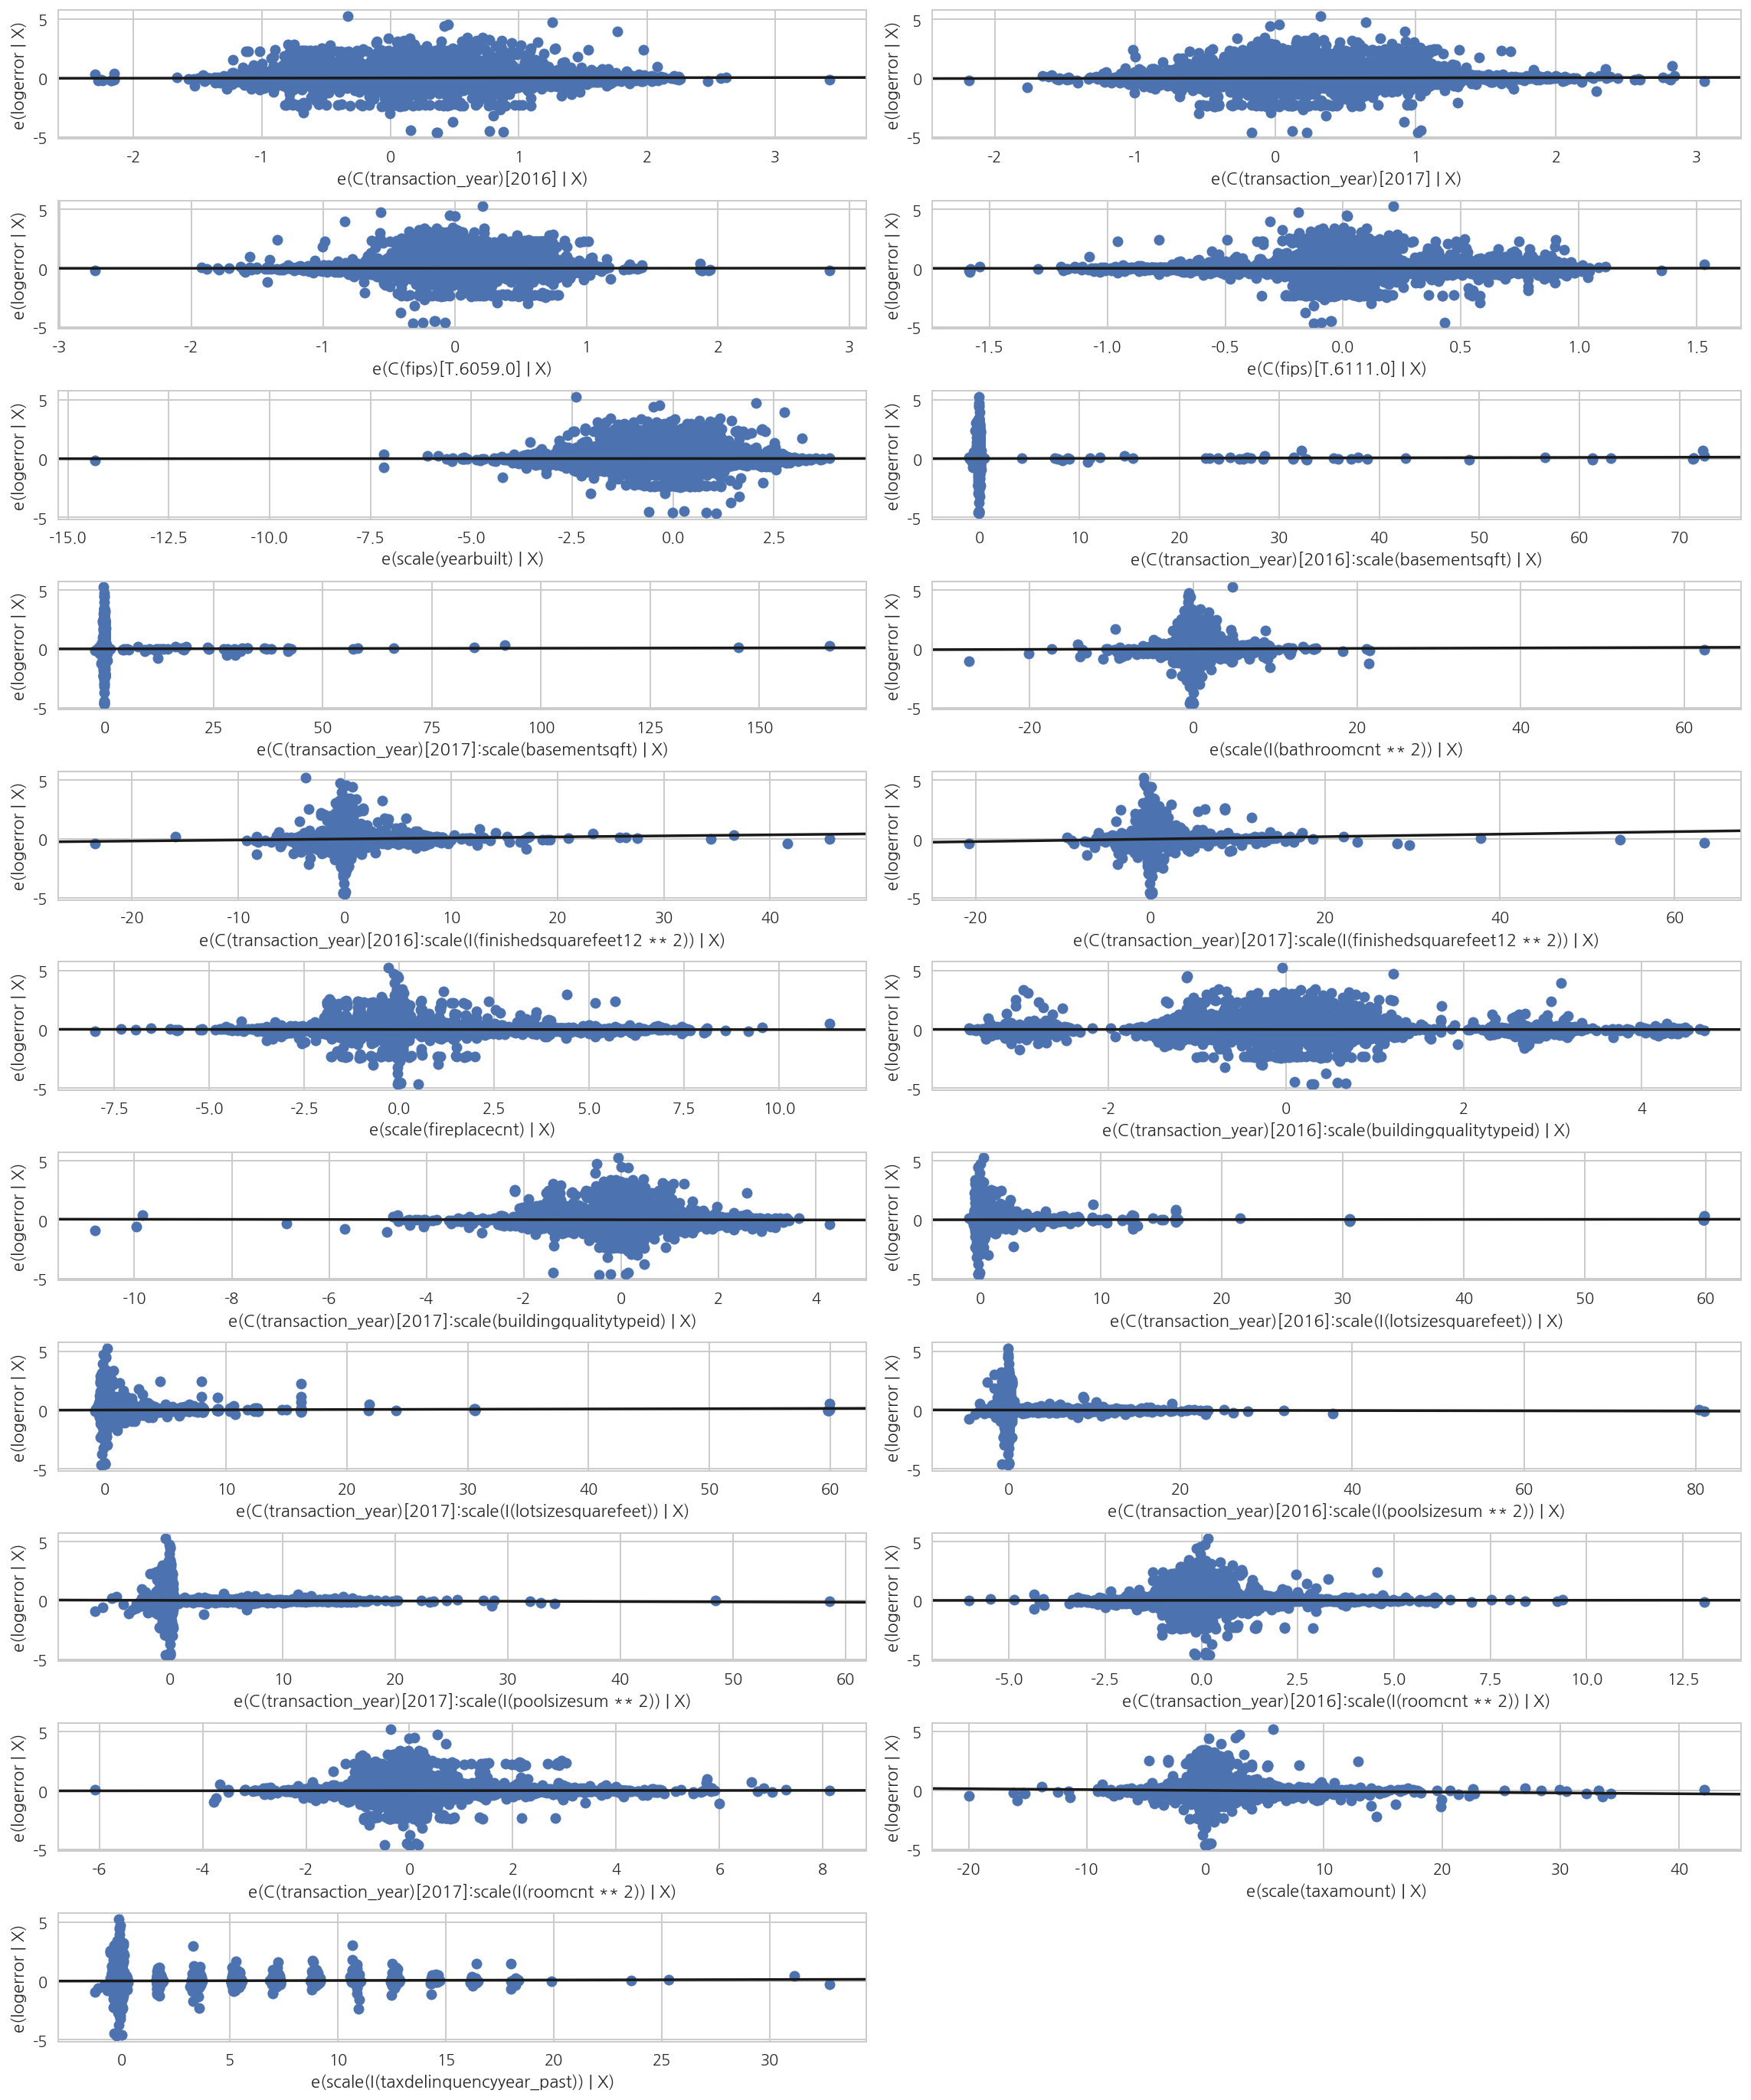

In [38]:
fig = plt.figure(figsize = (16, 20))
sm.graphics.plot_partregress_grid(result, fig=fig)
fig.suptitle("")
plt.show()

##### 잔차의 정규분포 테스트 결과는 p-value가 매우 낮음 → 정규분포를 따르지 않음

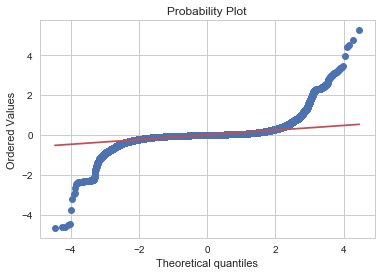

In [126]:
sp.stats.probplot(result.resid, plot=plt)
plt.show()

### 3.4 Outlier

##### 레버리지

In [128]:
# influence = result.get_influence()
# hat = influence.hat_matrix_diag

# plt.figure(figsize=(10,2))
# plt.stem(hat)
# plt.show()

##### 아웃라이어 - 표준화 잔차

In [129]:
# plt.figure(figsize=(10,2))
# plt.stem(result.resid_pearson)
# plt.show()

In [130]:
idx_r = np.where(result.resid_pearson > 2)[0]

##### Cook's distance

In [131]:
fox_cr

2.382852989884789e-05

In [132]:
influence = result.get_influence()
cooks_d2, pvals = influence.cooks_distance
fox_cr = 4 / (len(merged_1) - 21 - 1)
idx_c = np.where(cooks_d2 > fox_cr)[0]

In [133]:
resid_outliers = idx_r.tolist()
print("Standardized Residual Outliers", len(resid_outliers), "개 \n")

Standardized Residual Outliers 2971 개 



In [134]:
cooks_outliers = idx_c.tolist()
print("Cook's distance Outliers", len(cooks_outliers), "개 \n")

Cook's distance Outliers 4111 개 



In [135]:
outliers = set(resid_outliers) | set(cooks_outliers)

In [136]:
merged_1_outlier_del = merged_1.drop(outliers)

In [137]:
len(merged_1_outlier_del)

162585

## **4. Modeling**

In [138]:
model_y2 = sm.OLS.from_formula("logerror ~ C(transaction_year)+0 + C(fips) + scale(yearbuilt) + C(transaction_year):scale(basementsqft) +\
scale(I(bathroomcnt**2)) + C(transaction_year):scale(I(finishedsquarefeet12**2)) + scale(fireplacecnt) + C(transaction_year):scale(buildingqualitytypeid) +\
C(transaction_year):scale(I(lotsizesquarefeet)) + C(transaction_year):scale(I(poolsizesum**2)) + C(transaction_year):scale(I(roomcnt**2)) +\
scale(taxamount) + scale(I(taxdelinquencyyear_past))", 
                               data=merged_1_outlier_del, missing='drop')
result_2 = model_y2.fit()
print(result_2.summary())

                            OLS Regression Results                            
Dep. Variable:               logerror   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     81.74
Date:                Fri, 06 Jul 2018   Prob (F-statistic):               0.00
Time:                        15:41:39   Log-Likelihood:             1.8293e+05
No. Observations:              162585   AIC:                        -3.658e+05
Df Residuals:                  162564   BIC:                        -3.656e+05
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

#### 4.2.2 ANOVA F-test

In [139]:
sm.stats.anova_lm(result_2, typ=2)

,sum_sq,df,F,PR(>F)
C(transaction_year),1.914343,2.0,155.132097,4.911312e-68
C(fips),0.198928,2.0,16.120474,9.992201e-08
scale(yearbuilt),0.404957,1.0,65.632759,5.470012e-16
C(transaction_year):scale(basementsqft),0.021040,2.0,1.705012,1.817734e-01
scale(I(bathroomcnt ** 2)),0.268564,1.0,43.527081,4.194082e-11
C(transaction_year):scale(I(finishedsquarefeet12 ** 2)),2.806098,2.0,227.396928,2.402452e-99
scale(fireplacecnt),0.071402,1.0,11.572345,6.695607e-04
C(transaction_year):scale(buildingqualitytypeid),0.199419,2.0,16.160252,9.602610e-08
C(transaction_year):scale(I(lotsizesquarefeet)),0.067445,2.0,5.465524,4.230902e-03
C(transaction_year):scale(I(poolsizesum ** 2)),0.328504,2.0,26.620893,2.757948e-12


#### 4.2.4 Normalization of residuals

In [140]:
# Check the chi-squared and p-value of the residuals of the OLS model
test_norm = sms.omni_normtest(result_2.resid)
for xi in zip(['Chi^2', 'P-value'], test_norm):
    print("%-12s: %6.3f" % xi)

Chi^2       : 23177.011
P-value     :  0.000


In [ ]:
sp.stats.probplot(result.resid, plot=plt)
plt.show()

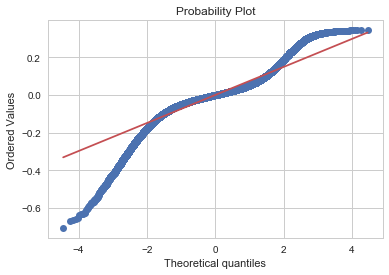

In [141]:
# Check the residual of OLS model with QQ Plot
sp.stats.probplot(result_2.resid, plot=plt)
plt.show()

### 4.3 Predict Logerror

# 2016

In [152]:
test_2016 = pd.read_csv('test_2016.csv')

In [165]:
test_2016['fips'] = test_2016['fips'].astype(str)

In [166]:
predict_2016 = result_2.predict(test_2016)

In [167]:
predict_2016_df = pd.DataFrame(columns=['201610','201611','201612'])

In [169]:
predict_2016_df['201610']=predict_2016
predict_2016_df['201611']=predict_2016
predict_2016_df['201612']=predict_2016

In [171]:
predict_2016_df.tail()

,201610,201611,201612
2985212,0.00084,0.00084,0.00084
2985213,0.00084,0.00084,0.00084
2985214,0.00084,0.00084,0.00084
2985215,0.00084,0.00084,0.00084
2985216,0.00084,0.00084,0.00084


# 2017

In [142]:
test_2017 = pd.read_csv('test_2017.csv')

In [145]:
test_2017['fips'] = test_2017['fips'].astype(str)

In [158]:
predict_2017 = result_2.predict(test_2017)

In [162]:
predict_2017_df = pd.DataFrame(columns=['201710','201711','201712'])

In [163]:
predict_2017_df['201710']=predict_2017
predict_2017_df['201711']=predict_2017
predict_2017_df['201712']=predict_2017

In [172]:
predict_2017_df.tail()

,201710,201711,201712
2985212,0.003394,0.003394,0.003394
2985213,0.003394,0.003394,0.003394
2985214,0.003394,0.003394,0.003394
2985215,0.003394,0.003394,0.003394
2985216,0.003394,0.003394,0.003394


# Make sample_submission.csv File

In [173]:
predict_df = pd.concat([predict_2016_df,predict_2017_df],axis=1)

In [175]:
parcelid = test_2017['parcelid']

In [184]:
result = pd.concat([parcelid,predict_df],axis=1).set_index('parcelid')

In [186]:
result.to_csv('sample_submission.csv')